In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
#     print(f'b = {b_curr}')
#     print(f'mu = {mu_curr}')
#     print(f'muM = {mu_curr * M}')
#     print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1= 26.4 
T2= 0.025
omega1= 0.0175
phi1=-1.5

R1= 250.083 #146.9
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=0.3
B=1.31
C=-2.4

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 #1/365
R_L = 300
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

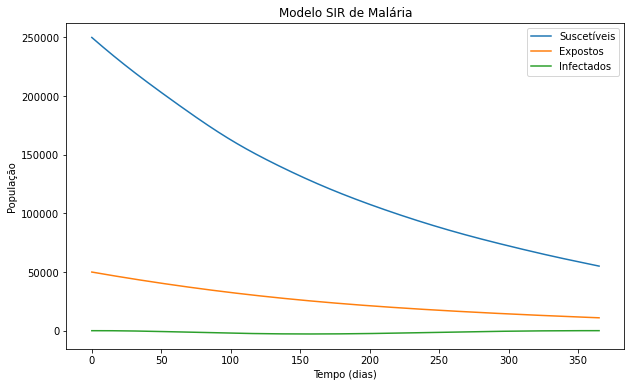

In [4]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

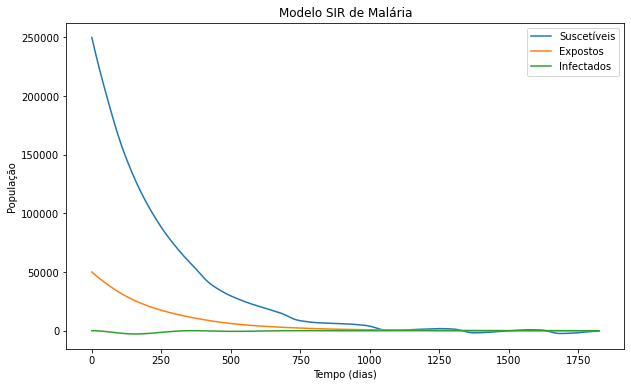

In [5]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

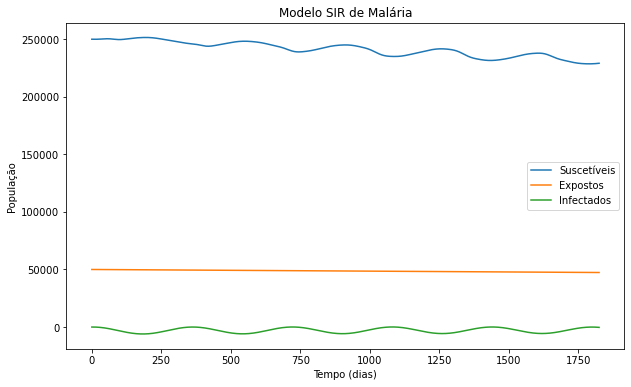

In [6]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 48.17725, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [7]:
S_M[-1]+E_M[-1]+I_M[-1]

276201.77700071916

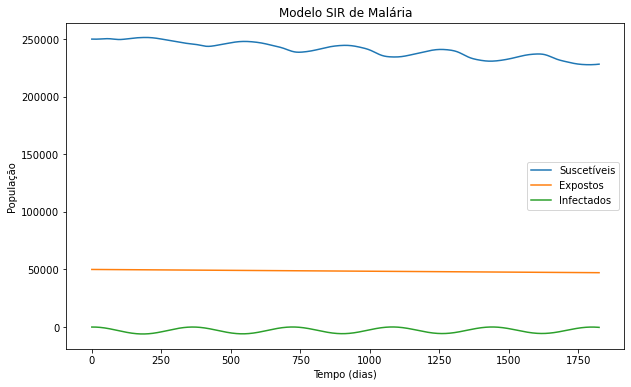

In [8]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 45, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [9]:
S_M[-1]+E_M[-1]+I_M[-1]

275149.16985600104

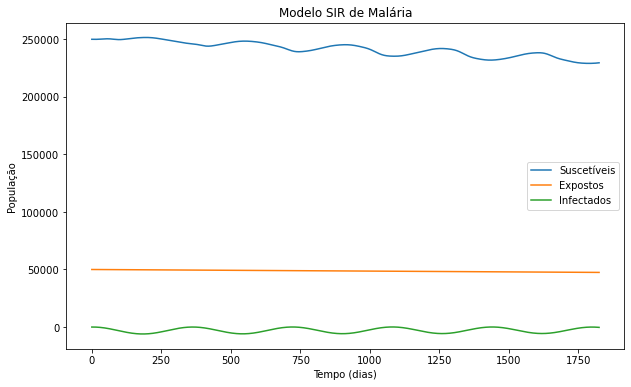

In [10]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 50, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [11]:
S_M[-1]+E_M[-1]+I_M[-1]

276747.5535005817

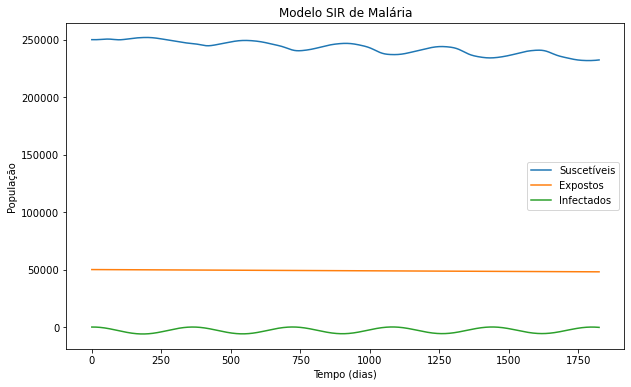

In [12]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 65, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [13]:
S_M[-1]+E_M[-1]+I_M[-1]

280110.41352201183

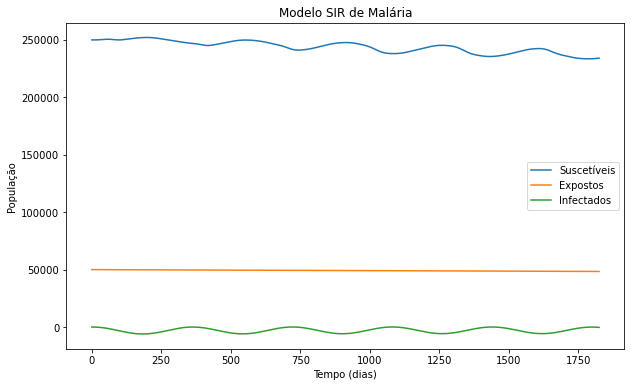

In [14]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 80, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [15]:
S_M[-1]+E_M[-1]+I_M[-1]

282235.76821486786

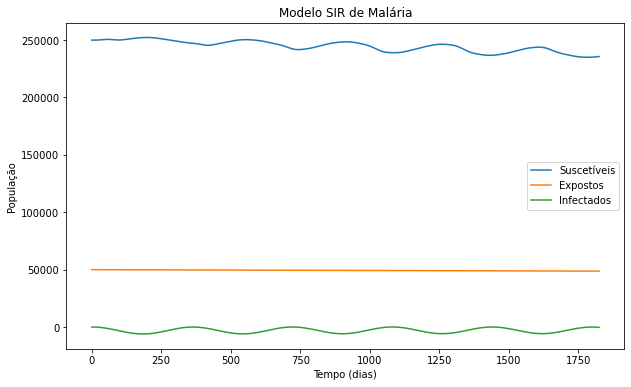

In [16]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 100, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [17]:
S_M[-1]+E_M[-1]+I_M[-1]

284094.9284154409

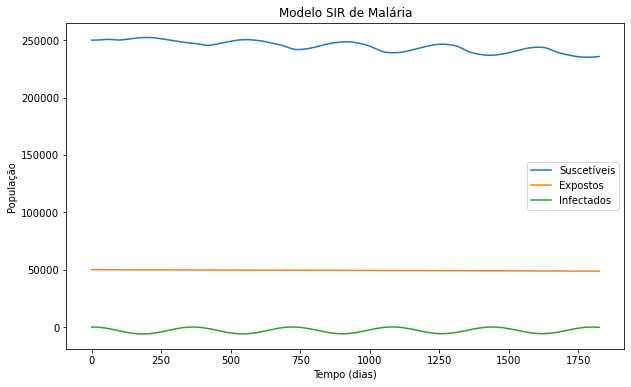

In [18]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 100, 25, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [19]:
S_M[-1]+E_M[-1]+I_M[-1]

284123.1424905418

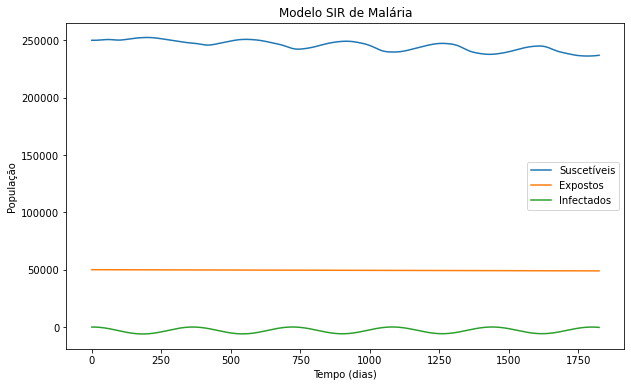

In [20]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 125, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [21]:
S_M[-1]+E_M[-1]+I_M[-1]

285593.8653487333

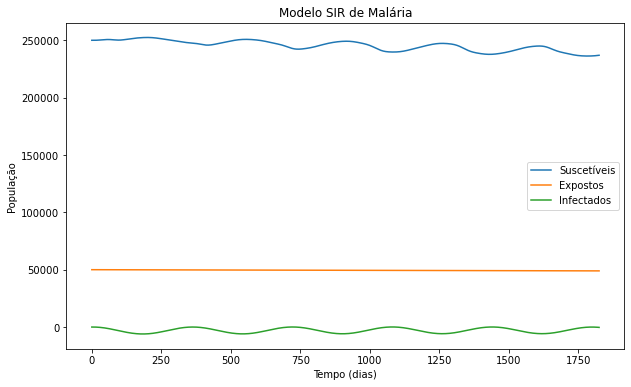

In [22]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 125, 15, -50, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [23]:
S_M[-1]+E_M[-1]+I_M[-1]

285597.3243753722

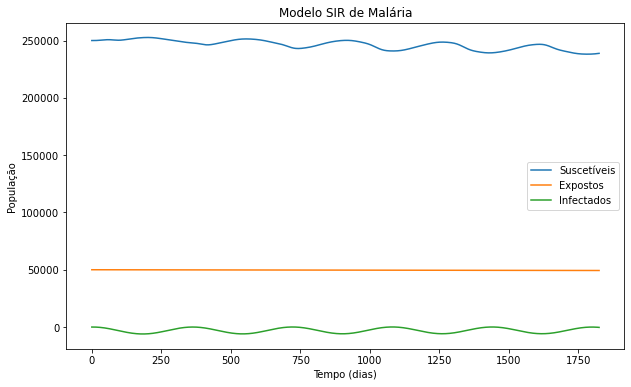

In [24]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 200, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [25]:
S_M[-1]+E_M[-1]+I_M[-1]

287861.8223600295

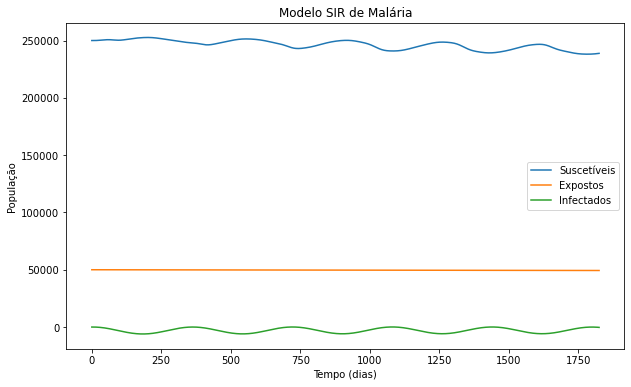

In [26]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 200, 5, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [27]:
S_M[-1]+E_M[-1]+I_M[-1]

287854.60533404845

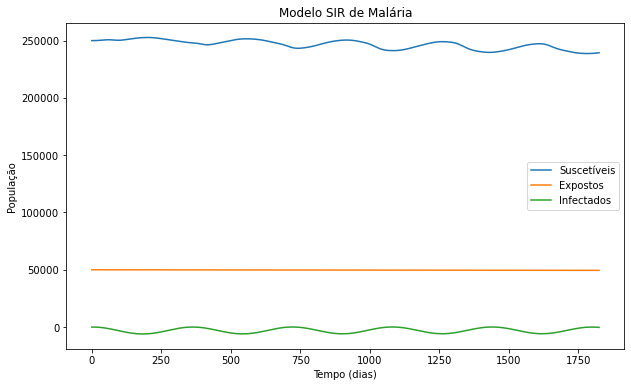

In [28]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 250, 15, -100, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [29]:
S_M[-1]+E_M[-1]+I_M[-1]

288623.0657768152

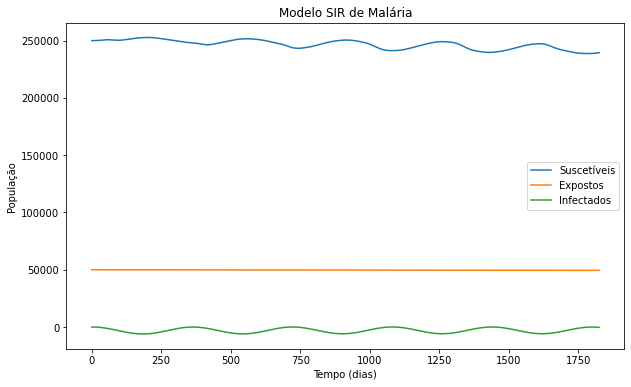

In [30]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 250, 15, -50, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [31]:
S_M[-1]+E_M[-1]+I_M[-1]

288623.94285606977

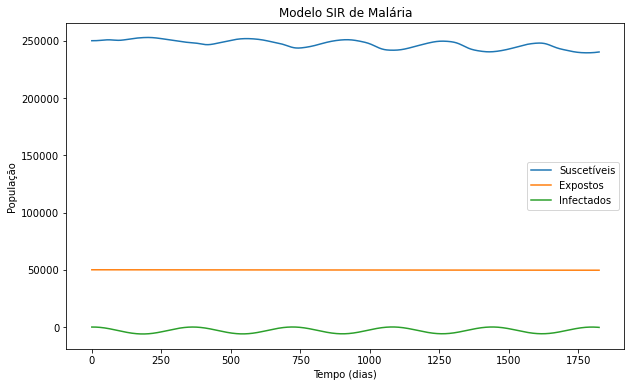

In [32]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 350, 15, -50, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [33]:
S_M[-1]+E_M[-1]+I_M[-1]

289496.74992087507

In [34]:
min(I_M)

-6046.893900992237

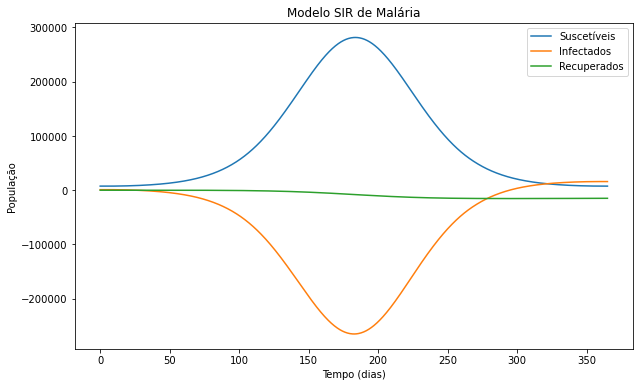

In [35]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [36]:
min(I_H)

-265006.174498318

In [37]:
S_H[-1]+I_H[-1]+R_H[-1]

8557.999999999656

In [38]:
# A, B, C = 450, 15, -50

# S_M[-1]+E_M[-1]+I_M[-1]
# 289736.5743283103

In [39]:
D1

36.5000000000000

In [40]:
# D1, A, B, C = 30, 450, 15, -50

# S_M[-1]+E_M[-1]+I_M[-1]
# 289737.20170208166

In [41]:
# D1, A, B, C = 40, 450, 15, -50

# S_M[-1]+E_M[-1]+I_M[-1]
# 289728.933496349

In [42]:
# A, B, C = 550, 15, -50

# S_M[-1]+E_M[-1]+I_M[-1]
# 290034.79192660336

In [43]:
R_L

300

In [44]:
R1

250.083000000000

In [45]:
# A, B, C, R_L = 550, 15, -50, 280

# S_M[-1]+E_M[-1]+I_M[-1]
# 248200.8319129902

In [46]:
# A, B, C, R_L = 450, 15, -50, 280

# S_M[-1]+E_M[-1]+I_M[-1]
# 247916.676266312

In [47]:
# A, B, C, R_L = 550, 15, -50, 320

# S_M[-1]+E_M[-1]+I_M[-1]
# 305328.7803458196

In [48]:
# A, B, C, R_L = 450, 15, -50, 320

# S_M[-1]+E_M[-1]+I_M[-1]
# 305010.5343361699

In [49]:
# A, B, C, R_L = 450, 15, -50, 310

# S_M[-1]+E_M[-1]+I_M[-1]
# 299313.618591143

In [50]:
# A, B, C, R_L = 450, 15, -50, 315

# S_M[-1]+E_M[-1]+I_M[-1]
# 302540.07315419876

In [51]:
# A, B, C, R_L = 400, 15, -50, 315

# S_M[-1]+E_M[-1]+I_M[-1]
# 302322.50936469325

In [52]:
# A, B, C, R_L = 400, 15, -50, 310

# S_M[-1]+E_M[-1]+I_M[-1]
# 299097.28984633624

In [53]:
# A, B, C, R_L = 400, 15, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300488.79732117156

In [54]:
# A, B, C, R_L = 300, 15, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299839.5229515738

In [55]:
# A, B, C, R_L = 300, 25, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299842.79467589903

In [56]:
# A, B, C, R_L = 300, 20, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299841.1598625682

In [57]:
# A, B, C, R_L = 275, 20, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299605.8507584944

In [58]:
# A, B, C, R_L = 300, 18, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299840.50507494016

In [59]:
# A, B, C, R_L = 300, 17.65, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299840.39122738846

In [60]:
# A, B, C, R_L = 300.5, 17.65, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299844.7029934594

In [61]:
# A, B, C, R_L = 299.85, 17.65, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299839.0944229401

In [62]:
# A, B, C, R_L = 300.15, 17.65, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299841.6861127034

In [63]:
# A, B, C, R_L = 300.15, 17.65, -48, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299841.710947848

In [64]:
# A, B, C, R_L = 300, 17.65, -50, 311.994575

# S_M[-1]+E_M[-1]+I_M[-1]
# 299836.7967362148

In [65]:
# A, B, C, R_L = 300, 17.65, -50, 311.99456

# S_M[-1]+E_M[-1]+I_M[-1]
# 299836.78678669315

In [66]:
# args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, 300.15, 17.65, -48, b2, tau_H, DD, Tmin, gamma, 312,
#                    N, M, E_M0, I_H0)

#300000.07007120183

# args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, 300.15, 17.65, -50, b2, tau_H, DD, Tmin, gamma, 312,
#                    N, M, E_M0, I_H0)

#299999.99374786695

In [67]:
300000.07007120183-300000

0.07007120182970539

In [68]:
300000-299999.99374786695

0.006252133051020792

In [69]:
D1

36.5000000000000

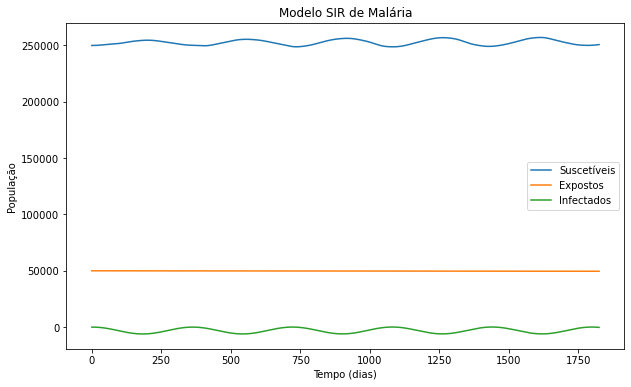

In [70]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 319.78, 15, -50, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [71]:
S_M[-1]+E_M[-1]+I_M[-1]

300174.504432574

In [72]:
300000.06144239753-300000

0.06144239753120928

In [73]:
300000-299999.9854784391

0.0145215608936269

In [74]:
300000.02357895504-300000

0.02357895503882901

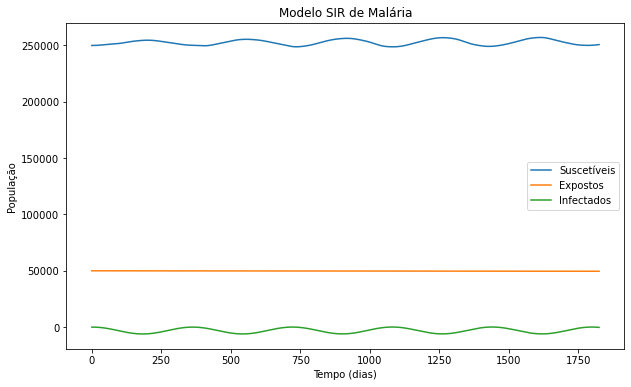

In [75]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 319.78, 15.05, -50, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [76]:
S_M[-1]+E_M[-1]+I_M[-1]

300174.5188758126

In [77]:
300000.0143502832-300000

0.0143502831924707

In [78]:
300000-299999.99989164615

0.0001083538481907453

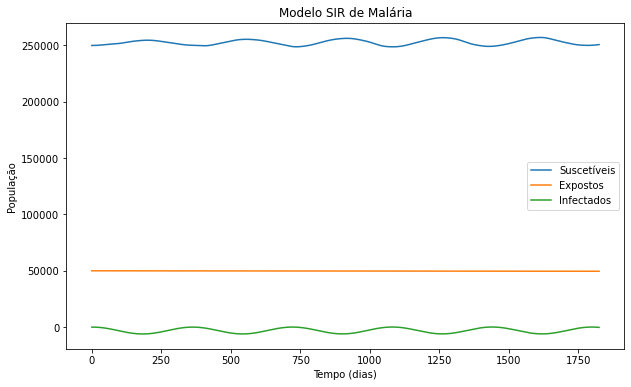

In [79]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 319.78, 15.05, -48, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [80]:
S_M[-1]+E_M[-1]+I_M[-1]

300174.5408001087

In [81]:
300000-299999.9993265225

0.000673477508826181

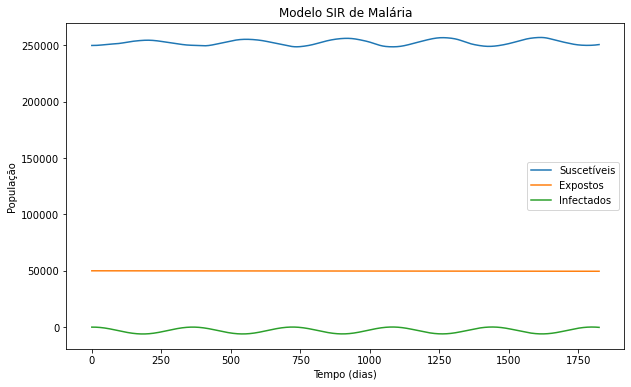

In [82]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 320, 15.05, -50, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [83]:
S_M[-1]+E_M[-1]+I_M[-1]

300176.1950673632

In [84]:
300001.67386230605-300000

1.673862306048250

In [85]:
# Para que seja usado um valor mais exato para a precipitação limite, os parâmetros decididos foram $A=319.78, \ B=15.05, \ C=-50$ e $R_L=312$, que tiveram uma diferença de aproximadamente 0.0001 para o valor real de mosquitos.

# Resultado obtido antes da correção dos parâmetros de temperatura

In [86]:
# A, B, C, R_L = 317.5, 15.05, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299996.71285112

In [87]:
# A, B, C, R_L = 318, 15.05, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.58050762763

In [88]:
# A, B, C, R_L = 317.95, 15, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.17962819035

In [89]:
300000.17962819035 - 300000

0.1796281903516501

In [90]:
# A, B, C, R_L = 317.9, 15, -50, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299999.7932803211

In [91]:
300000 - 299999.7932803211

0.206719678913942

In [92]:
# A, B, C, R_L = 317.925, 15, -48, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.0086993441

In [93]:
300000.0086993441 - 300000

0.00869934409274720

In [94]:
# A, B, C, R_L = 317.925, 15, -49, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299999.9975934489

In [95]:
300000 - 299999.9975934489

0.00240655109519139

In [96]:
# A, B, C, R_L = 317.925, 15, -48.75, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.0003645556

In [97]:
300000.0003645556 - 300000

0.000364555598935112

In [98]:
# A, B, C, R_L = 317.925, 15, -48.9, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299999.99870684784

In [99]:
300000 - 299999.99870684784

0.001293152159632882

In [100]:
# A, B, C, R_L = 317.925, 15, -48.7, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.0009204134

In [101]:
300000.0009204134 - 300000

0.000920413411222398

In [102]:
# A, B, C, R_L = 317.925, 15, -48.8, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 299999.9998128258

In [103]:
300000 - 299999.9998128258

0.000187174213351682

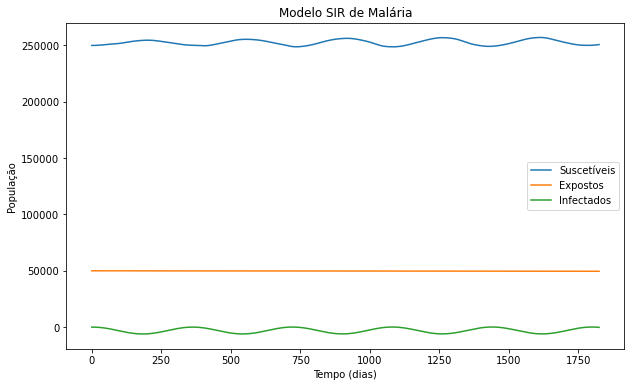

In [104]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, 312,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [105]:
# A, B, C, R_L = 317.925, 15, -48.78, 312

# S_M[-1]+E_M[-1]+I_M[-1]
# 300000.0000322461

In [106]:
300000.0000322461 - 300000

0.0000322461128234863

Para que seja usado um valor mais exato para a precipitação limite, os parâmetros decididos foram $A=317.925, \ B=15, \ C=-48.78$ e $R_L=312$, que tiveram uma diferença menor que 0.0001 para o valor real de mosquitos.